In [ ]:
!pip install patchify -q

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_root_folder = '/content/drive/MyDrive/'
dataset_name  = 'DubaiDataset'

In [ ]:
minmaxscaler = MinMaxScaler()

In [ ]:
image_patch_size = 256

In [ ]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
    image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [ ]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

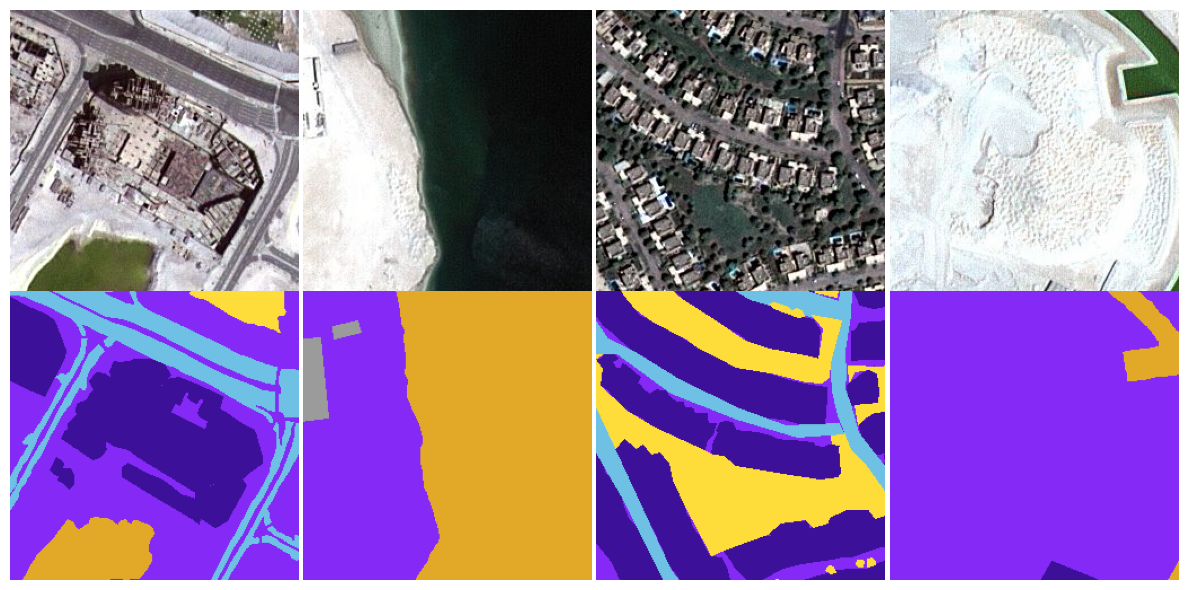

In [ ]:

indices_to_visualize = np.random.choice(len(image_dataset), 4, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices_to_visualize, 1):

    plt.subplot(2, 4, i)
    plt.imshow(image_dataset[idx])
    plt.axis('off')

    plt.subplot(2, 4, i + 4)
    plt.imshow(mask_dataset[idx], cmap='gray')
    plt.axis('off')

plt.tight_layout(h_pad=0.05, w_pad=0.2)
plt.show()

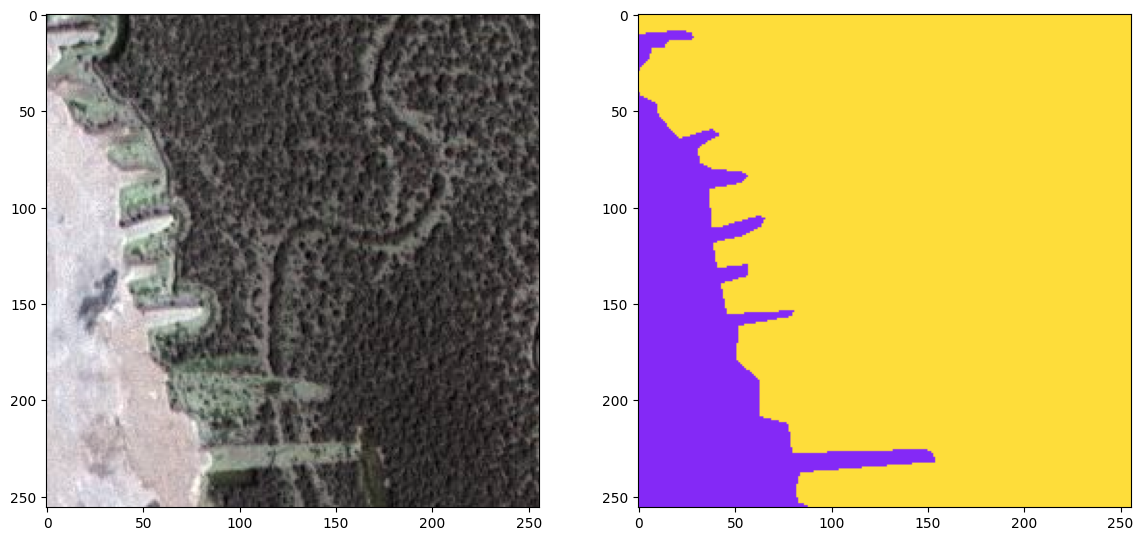

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [ ]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [ ]:
label = individual_patched_mask

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


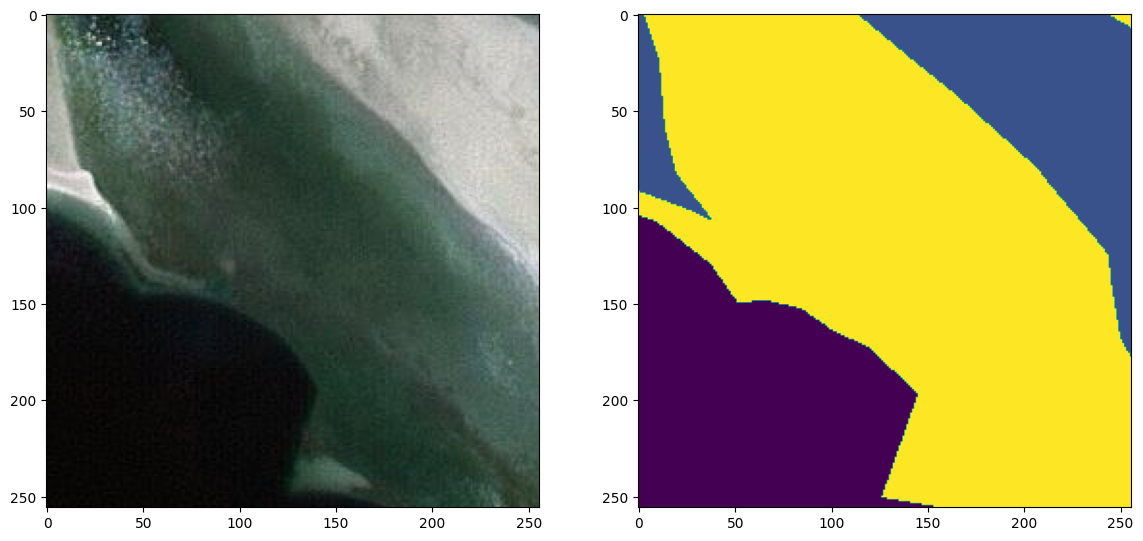

In [ ]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
master_training_dataset = image_dataset

In [ ]:
total_classes = len(np.unique(labels))
total_classes

6

In [ ]:
labels[0][:,:,0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
labels_categorical_dataset = to_categorical(labels, total_classes)
labels_categorical_dataset = labels_categorical_dataset.squeeze()
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.2, random_state=100)

print(X_train.shape)
print(X_temp.shape)
print(y_train.shape)
print(y_temp.shape)

(756, 256, 256, 3)
(189, 256, 256, 3)
(756, 256, 256, 6)
(189, 256, 256, 6)


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 100)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
image_height = X_train_tensor.shape[1]
image_width = X_train_tensor.shape[2]
image_channels = X_train_tensor.shape[3]
total_classes = y_train_tensor.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Deep Learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#General Model

class MultiUNet(nn.Module):
    def __init__(self, n_classes, image_height, image_width, image_channels):
        super(MultiUNet, self).__init__()

        #Encoder portion of UNet
        self.conv1 = DoubleConv(image_channels, 16)
        self.conv2 = DoubleConv(16, 32)
        self.conv3 = DoubleConv(32, 64)
        self.conv4 = DoubleConv(64, 128)
        self.conv5 = DoubleConv(128, 256)

        #Decoder portion of UNet
        self.upconv6 = UpConv(256, 128)
        self.conv6 = DoubleConv(256, 128)
        self.upconv7 = UpConv(128, 64)
        self.conv7 = DoubleConv(128, 64)
        self.upconv8 = UpConv(64, 32)
        self.conv8 = DoubleConv(64, 32)
        self.upconv9 = UpConv(32, 16)
        self.conv9 = DoubleConv(32, 16)

        self.outconv = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        #Perform encoding
        c1 = self.conv1(x)
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.conv2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.conv3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        c4 = self.conv4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        c5 = self.conv5(p4)

        #Perform decoding
        up6 = self.upconv6(c5, c4)
        c6 = self.conv6(up6)
        up7 = self.upconv7(c6, c3)
        c7 = self.conv7(up7)
        up8 = self.upconv8(c7, c2)
        c8 = self.conv8(up8)
        up9 = self.upconv9(c8, c1)
        c9 = self.conv9(up9)

        output = self.outconv(c9)
        return F.log_softmax(output, dim=1)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.double_conv(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        return torch.cat([x2, x1], dim=1)

model = MultiUNet(n_classes=total_classes, image_height = image_height, image_width = image_width, image_channels=image_channels)

print(model)

MultiUNet(
  (conv1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv4): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=

In [ ]:
#Batch Normalization Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiUNet(nn.Module):
    def __init__(self, n_classes, image_height, image_width, image_channels):
        super(MultiUNet, self).__init__()

        self.conv1 = DoubleConv(image_channels, 16)
        self.conv2 = DoubleConv(16, 32)
        self.conv3 = DoubleConv(32, 64)
        self.conv4 = DoubleConv(64, 128)
        self.conv5 = DoubleConv(128, 256)

        self.upconv6 = UpConv(256, 128)
        self.conv6 = DoubleConv(256, 128)
        self.upconv7 = UpConv(128, 64)
        self.conv7 = DoubleConv(128, 64)
        self.upconv8 = UpConv(64, 32)
        self.conv8 = DoubleConv(64, 32)
        self.upconv9 = UpConv(32, 16)
        self.conv9 = DoubleConv(32, 16)

        self.outconv = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.conv2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.conv3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        c4 = self.conv4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        c5 = self.conv5(p4)

        up6 = self.upconv6(c5, c4)
        c6 = self.conv6(up6)
        up7 = self.upconv7(c6, c3)
        c7 = self.conv7(up7)
        up8 = self.upconv8(c7, c2)
        c8 = self.conv8(up8)
        up9 = self.upconv9(c8, c1)
        c9 = self.conv9(up9)

        output = self.outconv(c9)
        return F.log_softmax(output, dim=1)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.double_conv(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        x1 = self.batch_norm(x1)
        return torch.cat([x2, x1], dim=1)

model = MultiUNet(n_classes=total_classes, image_height=image_height, image_width=image_width, image_channels=image_channels)

print(model)

MultiUNet(
  (conv1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs_flat = inputs.reshape(-1)
        targets_flat = targets.reshape(-1)

        intersection = torch.sum(inputs_flat * targets_flat)
        dice_coefficient = (2.0 * intersection + self.smooth) / (torch.sum(inputs_flat) + torch.sum(targets_flat) + self.smooth)

        dice_loss = 1.0 - dice_coefficient
        return dice_loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            focal_loss = self.alpha * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class TotalLoss(nn.Module):
    def __init__(self, dice_weight=0.3, focal_weight=0.7):
        super(TotalLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        dice_term = self.dice_loss(inputs, targets)
        focal_term = self.focal_loss(inputs, targets)

        total_loss = self.dice_weight * dice_term + self.focal_weight * focal_term
        return total_loss

In [ ]:
!pip install -U torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.1 MB/s eta 0:00:00


Epoch [1/100], Train Loss: 0.4816193512330453, Train IoU: 0.4612581729888916, Val Loss: 0.4908832063277562, Val IoU: 0.47536414861679077
Epoch [2/100], Train Loss: 0.4790962226688862, Train IoU: 0.4805968403816223, Val Loss: 0.44876863559087116, Val IoU: 0.5032526850700378
Epoch [3/100], Train Loss: 0.4747755229473114, Train IoU: 0.4753496050834656, Val Loss: 0.47182319064935047, Val IoU: 0.4838840663433075
Epoch [4/100], Train Loss: 0.4592998183021943, Train IoU: 0.5002462863922119, Val Loss: 0.5016704102357229, Val IoU: 0.4849320650100708
Epoch [5/100], Train Loss: 0.4566846756885449, Train IoU: 0.4953291118144989, Val Loss: 0.4624166190624237, Val IoU: 0.5145468711853027
Epoch [6/100], Train Loss: 0.45087947758535546, Train IoU: 0.5047153830528259, Val Loss: 0.4383344699939092, Val IoU: 0.5247765779495239
Epoch [7/100], Train Loss: 0.4516030264397462, Train IoU: 0.509258508682251, Val Loss: 0.4442887951930364, Val IoU: 0.5042537450790405
Epoch [8/100], Train Loss: 0.4514236003160476

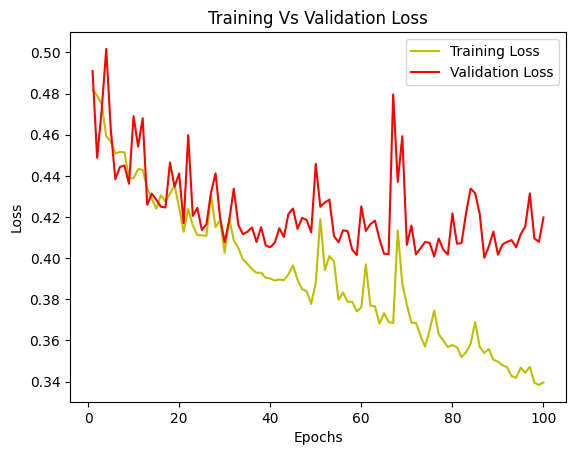

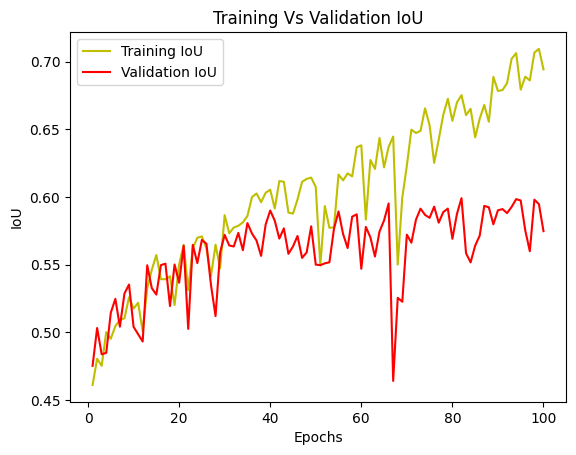

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex as IoU
import matplotlib.pyplot as plt

device = torch.device('cuda')
model = model.to(device)

criterion = TotalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iou = IoU(task = 'multiclass', num_classes=total_classes)
iou = iou.to(device)

num_epochs = 100
train_losses = []
val_losses = []
train_ious = []
val_ious = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.permute(0,3,1,2).to(device)
        targets = targets.permute(0,3,1,2).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        probs = F.softmax(outputs, dim = 1)
        preds = torch.argmax(probs, dim = 1)
        running_iou += iou(targets, preds)

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_iou = running_iou / len(train_loader)
    train_losses.append(train_loss)
    train_ious.append(train_iou)

    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.permute(0,3,1,2).to(device)
            targets = targets.permute(0,3,1,2).to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim = 1)
            preds = torch.argmax(probs, dim = 1)

            val_iou += iou(targets, preds)

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss}, Train IoU: {train_iou}, '
          f'Val Loss: {val_loss}, Val IoU: {val_iou}')

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label="Training Loss")
plt.plot(epochs, val_losses, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

train_ious_cpu = [iou.cpu().item() for iou in train_ious]
val_ious_cpu = [iou.cpu().item() for iou in val_ious]
plt.plot(epochs, train_ious_cpu, 'y', label="Training IoU")
plt.plot(epochs, val_ious_cpu, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

Epoch [1/100], Train Loss: 0.9376742703219255, Train IoU: 0.1717529296875, Val Loss: 0.8215856452782949, Val IoU: 0.26005396246910095
Epoch [2/100], Train Loss: 0.8164273413519064, Train IoU: 0.31485018134117126, Val Loss: 0.7516006330649058, Val IoU: 0.42251789569854736
Epoch [3/100], Train Loss: 0.770034751544396, Train IoU: 0.3870571553707123, Val Loss: 0.7273685534795126, Val IoU: 0.4357379376888275
Epoch [4/100], Train Loss: 0.7327096251149973, Train IoU: 0.42679545283317566, Val Loss: 0.7191750605901083, Val IoU: 0.38011711835861206
Epoch [5/100], Train Loss: 0.7148789279162884, Train IoU: 0.44082579016685486, Val Loss: 0.6895391643047333, Val IoU: 0.4145805835723877
Epoch [6/100], Train Loss: 0.6963432605067889, Train IoU: 0.4432607889175415, Val Loss: 0.6593889395395914, Val IoU: 0.4962785243988037
Epoch [7/100], Train Loss: 0.6704412500063578, Train IoU: 0.47790056467056274, Val Loss: 0.643080989519755, Val IoU: 0.5172795653343201
Epoch [8/100], Train Loss: 0.6573959837357203,

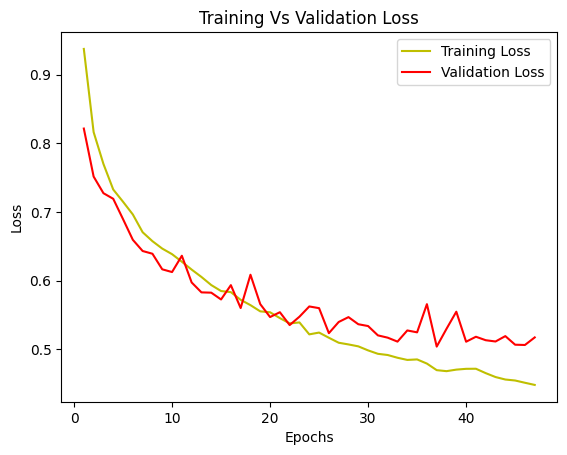

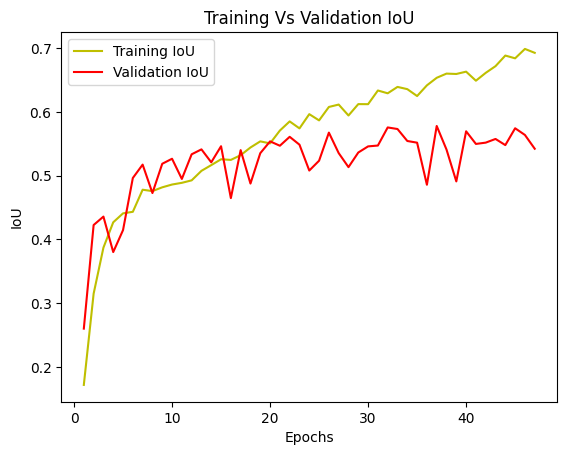

In [ ]:
#Training with early stopping

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex as IoU
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

criterion = TotalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
iou = IoU(task='multiclass', num_classes=total_classes).to(device)

num_epochs = 100
train_losses = []
val_losses = []
train_ious = []
val_ious = []

best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        targets = targets.permute(0, 3, 1, 2).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        running_iou += iou(targets, preds)

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_iou = running_iou / len(train_loader)
    train_losses.append(train_loss)
    train_ious.append(train_iou)

    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            targets = targets.permute(0, 3, 1, 2).to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            val_iou += iou(targets, preds)

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss}, Train IoU: {train_iou}, '
          f'Val Loss: {val_loss}, Val IoU: {val_iou}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

epochs = range(1, epoch + 2)
plt.plot(epochs, train_losses, 'y', label="Training Loss")
plt.plot(epochs, val_losses, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

train_ious_cpu = [iou.cpu().item() for iou in train_ious]
val_ious_cpu = [iou.cpu().item() for iou in val_ious]
plt.plot(epochs, train_ious_cpu, 'y', label="Training IoU")
plt.plot(epochs, val_ious_cpu, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

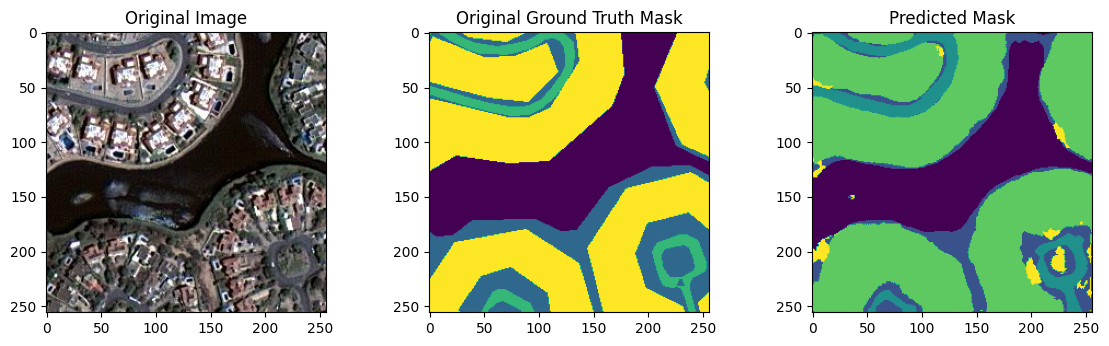

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
model.to(device)

test_image_number = 4

test_image_rgb = X_test[test_image_number][:,:,:3]

test_image_tensor = torch.tensor(test_image_rgb, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)

ground_truth_mask_index = torch.argmax(y_test_tensor[test_image_number], dim=2).cpu().numpy()

ground_truth_mask_rgb = np.zeros_like(test_image_rgb, dtype=np.uint8)
ground_truth_mask_rgb[ground_truth_mask_index == 0] = class_water
ground_truth_mask_rgb[ground_truth_mask_index == 1] = class_land
ground_truth_mask_rgb[ground_truth_mask_index == 2] = class_road
ground_truth_mask_rgb[ground_truth_mask_index == 3] = class_building
ground_truth_mask_rgb[ground_truth_mask_index == 4] = class_vegetation
ground_truth_mask_rgb[ground_truth_mask_index == 5] = class_unlabeled

ground_truth_mask = rgb_to_label(ground_truth_mask_rgb)

with torch.no_grad():
    model_output = model(test_image_tensor)
    predicted_mask_probs = F.softmax(model_output, dim=1)
    predicted_mask = torch.argmax(predicted_mask_probs, dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(14, 8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())

plt.subplot(232)
plt.title("Original Ground Truth Mask")
plt.imshow(ground_truth_mask)

plt.subplot(233)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)

plt.show()

In [ ]:
model.eval()
model.to(device)

all_ground_truth_masks = []
all_predicted_masks = []

for test_image_number in range(len(X_test)):
    test_image_rgb = X_test[test_image_number][:, :, :3]

    test_image_tensor = torch.tensor(test_image_rgb, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)

    ground_truth_mask_index = torch.argmax(y_test_tensor[test_image_number], dim=2).cpu().numpy()

    ground_truth_mask_rgb = np.zeros_like(test_image_rgb, dtype=np.uint8)
    ground_truth_mask_rgb[ground_truth_mask_index == 0] = class_water
    ground_truth_mask_rgb[ground_truth_mask_index == 1] = class_land
    ground_truth_mask_rgb[ground_truth_mask_index == 2] = class_road
    ground_truth_mask_rgb[ground_truth_mask_index == 3] = class_building
    ground_truth_mask_rgb[ground_truth_mask_index == 4] = class_vegetation
    ground_truth_mask_rgb[ground_truth_mask_index == 5] = class_unlabeled

    ground_truth_mask = rgb_to_label(ground_truth_mask_rgb)

    with torch.no_grad():
        model_output = model(test_image_tensor)
        predicted_mask_probs = F.softmax(model_output, dim=1)
        predicted_mask = torch.argmax(predicted_mask_probs, dim=1).squeeze().cpu().numpy()

    all_ground_truth_masks.append(ground_truth_mask)
    all_predicted_masks.append(predicted_mask)

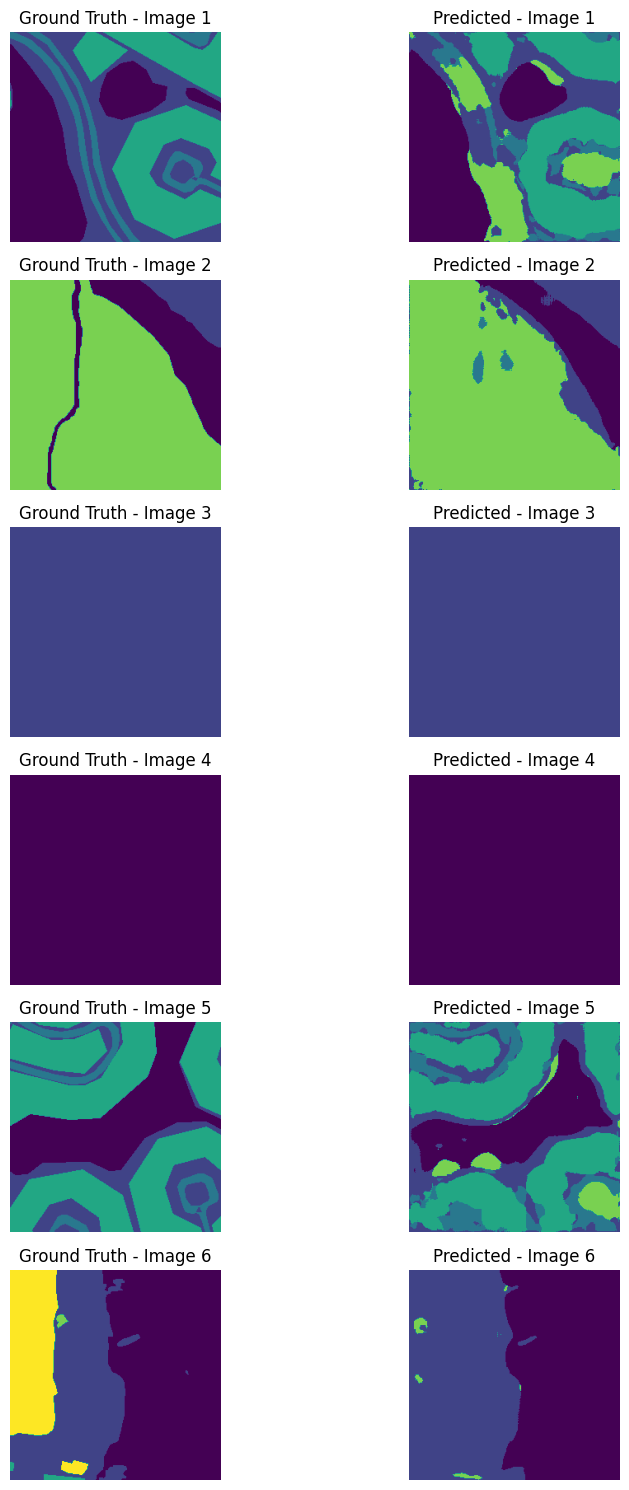

In [ ]:
num_images_to_plot = 6
num_classes = 6

fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(10, 15))

for i in range(num_images_to_plot):
    axes[i, 0].imshow(all_ground_truth_masks[i], cmap='viridis', vmin=0, vmax=num_classes - 1)
    axes[i, 0].set_title(f'Ground Truth - Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(all_predicted_masks[i], cmap='viridis', vmin=0, vmax=num_classes - 1)
    axes[i, 1].set_title(f'Predicted - Image {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import jaccard_score

all_jaccard_indices = []

for i in range(len(X_test)):
    ground_truth_mask = all_ground_truth_masks[i].flatten()
    predicted_mask = all_predicted_masks[i].flatten()

    jaccard_index = jaccard_score(ground_truth_mask, predicted_mask, average='micro')
    all_jaccard_indices.append(jaccard_index)

average_jaccard_index = sum(all_jaccard_indices) / len(all_jaccard_indices)

print(f"Average Jaccard Index on the test set: {average_jaccard_index}")

Average Jaccard Index on the test set: 0.7754662859574778


# Saving and reloading model

In [ ]:
torch.save(model.state_dict(), 'satellite_segementation_fullV1.h5')

In [ ]:
saved_model = MultiUNet(n_classes=total_classes, image_height=image_height, image_width=image_width, image_channels=image_channels)
saved_model.load_state_dict(torch.load('/content/satellite_segementation_fullV1.h5'))
saved_model.eval()

MultiUNet(
  (conv1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv4): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=

# Testing model on custom images

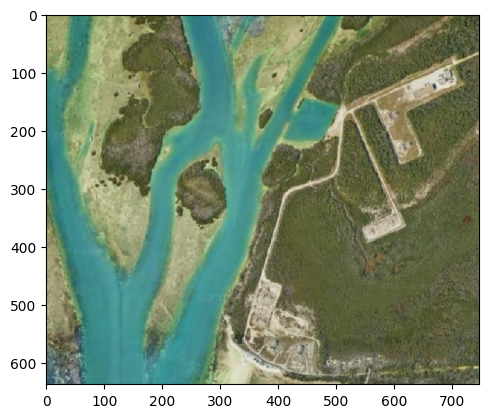

In [ ]:
plt.imshow(Image.open('/content/test2.jpg'))

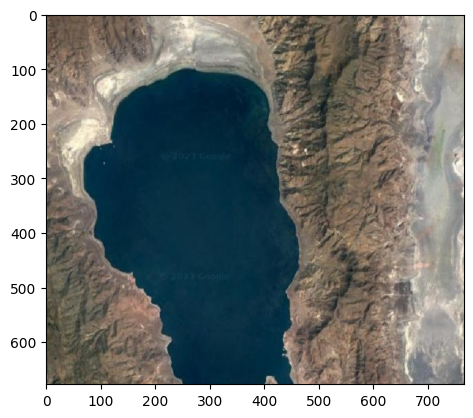

In [ ]:
plt.imshow(Image.open('/content/test3.jpg'))

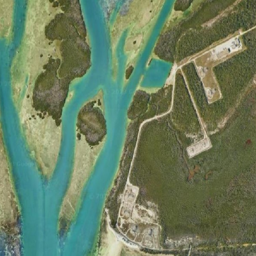

In [ ]:
image = Image.open('/content/test2.jpg')
image = image.resize((256, 256))
image

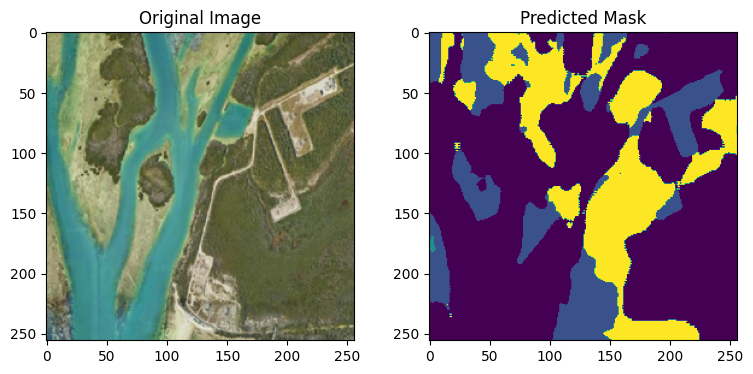

In [ ]:
image = Image.open('/content/test2.jpg')
image = image.resize((256, 256))
image = np.array(image)

image = image / 255.0

image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)

with torch.no_grad():
    model_output = saved_model(image_tensor).to(device)
    predicted_mask_probs = F.softmax(model_output, dim=1)
    predicted_mask = torch.argmax(predicted_mask_probs, dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.title("Original Image")
plt.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().numpy())

plt.subplot(132)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)

plt.show()